# <font color=red> **Comparison of GARCH-(1,1) variants and Stochastic Volatility Model** </font>

## <font color=cyan> Downloading NIFTY50 data from 2007-09-17 upto 2021-12-31 </font>

In [1]:
#loading required libraries and downloading data using tseries library's get.hist.quote function
library(tseries)
library(zoo)
library(parallel)
library(rugarch)
library(pbapply)

nifty <- get.hist.quote("^NSEI", end="2022-01-01", quote="Adjusted")
nifty[!is.na(nifty)] -> nifty

logret <- diff(log(nifty))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Warning message:
"^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


time series starts 2007-09-17
time series ends   2021-12-31


In [2]:
#Saving available GARCH-(1,1) variants in rugarch library to a variable 
model_name <- c("sGARCH","eGARCH","iGARCH","apARCH","gjrGARCH","csGARCH")

In [3]:
# Using skewed student t-distribution to account for leverage and symmetry effect in financial return series
pboptions(type="timer")

system.time(uspec <- pblapply(model_name, FUN = function(x){
    ugarchspec(variance.model = list(model=x, garchOrder=c(1,1)),
               mean.model = list(armaOrder=c(0,0), include.mean=TRUE),
               distribution.model = "sstd")
}))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


   user  system elapsed 
   0.16    0.04    0.39 

In [4]:
#Checking number of cores available for parallel computing
library(benchmarkme)

benchmarkme::get_cpu()

$vendor_id
[1] "GenuineIntel"

$model_name
[1] "Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz"

$no_of_cores
[1] 8

In [5]:
#Making clusters for parallel computing 
cl = makePSOCKcluster(8)

#Estimating VaR at 90%,95% and 99% confidence intervals for backtesting on NIFTY50 returns for various GARCH models
which(index(logret)=="2020-12-31")
system.time(VaR_nifty_2021 <- pblapply(uspec, FUN = function(x){
              roll.garch  <-    ugarchroll(x,
                                data=logret,
                                n.ahead = 1,
                                forecast.length = 1,
                                n.start = 3250,
                                refit.every = 1,
                                refit.window = "recursive",
                                calculate.VaR = T,
                                VaR.alpha = c(0.1,0.05,0.01),
                                cluster = cl,
                                keep.coef=T)
             roll.garch@forecast$VaR
}))

[1] 3250

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09m 39s


   user  system elapsed 
   0.25    0.64  579.19 

In [6]:
#Saving available sub-variants of FGARCH model to a variable
submodels_fgarch <- c("GARCH","TGARCH","AVGARCH","NGARCH","NAGARCH","APARCH","GJRGARCH","ALLGARCH")

In [7]:
#Making a list of ugarchspec objects for various fGARCH variants
system.time(uspecs_fgarch <- pblapply(submodels_fgarch, FUN = function(x){
    ugarchspec(variance.model = list(model="fGARCH", garchOrder=c(1,1), submodel = x),
               mean.model = list(armaOrder=c(0,0), include.mean=TRUE),
               distribution.model = "sstd")
}))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


   user  system elapsed 
   0.02    0.00    0.03 

In [8]:
# Estimating VaR at 90%,95% and 99% confidence intervals for NIFTY50 returns for various fGARCH variants
system.time(VaR_nifty_fgarch_2021 <- pblapply(uspecs_fgarch, FUN = function(x){
              roll.garch  <-    ugarchroll(x,
                                data=logret,
                                n.ahead = 1,
                                forecast.length = 1,
                                n.start = 3250,
                                refit.every = 1,
                                refit.window = "recursive",
                                calculate.VaR = T,
                                VaR.alpha = c(0.1,0.05,0.01),
                                cluster = cl,
                                keep.coef=T)
             roll.garch@forecast$VaR
}))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=20m 32s


   user  system elapsed 
   0.39    0.36 1232.37 

In [9]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2487092,132.9,4572895,244.3,4572895,244.3
Vcells,6548927,50.0,12255594,93.6,11967494,91.4


In [10]:
library(stochvol)

# Calling MCMC (Markov Chain Monte Carlo) sampler with 11,000 iterations for Stochastic Volatility Forecasting
system.time(VaR_nifty_stochvol_2021 <- svtlsample_roll(y=logret,
                                                      designmatrix="ar1",
                                                      n_ahead=1,
                                                      forecast_length=1,
                                                      n_start=3250,
                                                      refit_every=1,
                                                      refit_window="expanding",
                                                      calculate_quantile=c(0.1,0.05,0.01),
                                                      calculate_predictive_likelihood=TRUE,
                                                      parallel = "multicore",
                                                      cl = cl,
                                                      ))


Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing poster

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior draws...

Done!

Summarizing posterior dra

    user   system  elapsed 
 5137.19   212.15 13516.05 

In [11]:
# Saving R Workspace for backup
save.image("GARCH_variants_and_stochvol_model.RData")

# <font color = green> **Aggregating data into data tables for Comparative Analysis of Results** </font>

In [13]:
library(data.table)
VaR_nifty50_stochvol_2021 <- rbindlist(lapply(VaR_nifty_stochvol_2021, FUN = function(x){as.data.table(t(x$predicted_quantile))}))


Attaching package: 'data.table'


The following object is masked _by_ '.GlobalEnv':

    .N




In [14]:
VaR_nifty50_stochvol_2021[,realized:=logret[3251:3498]]

In [15]:
sapply(VaR_nifty50_stochvol_2021, class)

10%        5%        1%  realized 
"numeric" "numeric" "numeric"     "zoo"

In [17]:
VaR_nifty50_stochvol_2021[,realized:=as.numeric(realized)]
head(VaR_nifty50_stochvol_2021,10)

10%,5%,1%,realized
<dbl>,<dbl>,<dbl>,<dbl>
-0.009681939,-0.01313713,-0.02104849,2.624978e-03
-0.009215796,-0.01236611,-0.02090738,8.127555e-03
-0.009224827,-0.01264877,-0.02027644,4.701312e-03
-0.009098872,-0.01253075,-0.02076290,-3.757181e-03
-0.009324913,-0.01257106,-0.02039714,-6.293676e-04
-0.009253357,-0.01279029,-0.02119413,1.473808e-02
-0.009458761,-0.01268592,-0.02095280,9.538086e-03
-0.009389271,-0.01291528,-0.02091323,5.418607e-03
-0.009061566,-0.01230890,-0.02035696,9.608621e-05


In [20]:
VaR_nifty50_garch_2021 <- rbindlist(VaR_nifty_2021)
VaR_nifty50_fgarch_2021 <- rbindlist(VaR_nifty_fgarch_2021)

head(VaR_nifty50_garch_2021,10)
head(VaR_nifty50_fgarch_2021,10)

alpha(10%),alpha(5%),alpha(1%),realized
<dbl>,<dbl>,<dbl>,<dbl>
-0.01169482,-0.01602032,-0.02591765,2.624978e-03
-0.01125619,-0.01542899,-0.02497731,8.127555e-03
-0.01111075,-0.01523045,-0.02465174,4.701312e-03
-0.01076083,-0.01476673,-0.02394906,-3.757181e-03
-0.01045101,-0.01434102,-0.02324103,-6.293676e-04
-0.01006417,-0.01381829,-0.02241025,1.473808e-02
-0.01080031,-0.01481308,-0.02399015,9.538086e-03
-0.01081415,-0.01483375,-0.02402766,5.418607e-03
-0.01052096,-0.01443908,-0.02340287,9.608621e-05


alpha(10%),alpha(5%),alpha(1%),realized
<dbl>,<dbl>,<dbl>,<dbl>
-0.01169369,-0.01601796,-0.02590990,2.624978e-03
-0.01125628,-0.01542790,-0.02497155,8.127555e-03
-0.01110027,-0.01522135,-0.02464968,4.701312e-03
-0.01076435,-0.01476281,-0.02390538,-3.757181e-03
-0.01045734,-0.01435051,-0.02326016,-6.293676e-04
-0.01005865,-0.01381207,-0.02240562,1.473808e-02
-0.01079986,-0.01481159,-0.02398825,9.538086e-03
-0.01081331,-0.01483282,-0.02402584,5.418607e-03
-0.01051815,-0.01443516,-0.02339818,9.608621e-05


In [21]:
nrow(VaR_nifty50_garch_2021)
nrow(VaR_nifty50_fgarch_2021)

[1] 1488

[1] 1984

In [22]:
colnames(VaR_nifty50_stochvol_2021) <- colnames(VaR_nifty50_garch_2021)

sapply(VaR_nifty50_garch_2021,class)
sapply(VaR_nifty50_fgarch_2021,class)

alpha(10%)  alpha(5%)  alpha(1%)   realized 
 "numeric"  "numeric"  "numeric"  "numeric"

alpha(10%)  alpha(5%)  alpha(1%)   realized 
 "numeric"  "numeric"  "numeric"  "numeric"

In [23]:
rbindlist(list(VaR_nifty50_garch_2021, VaR_nifty50_fgarch_2021,VaR_nifty50_stochvol_2021)) -> VaR_nifty50_2021

In [24]:
nrow(VaR_nifty50_2021)
head(VaR_nifty50_2021,10)

[1] 3720

alpha(10%),alpha(5%),alpha(1%),realized
<dbl>,<dbl>,<dbl>,<dbl>
-0.01169482,-0.01602032,-0.02591765,2.624978e-03
-0.01125619,-0.01542899,-0.02497731,8.127555e-03
-0.01111075,-0.01523045,-0.02465174,4.701312e-03
-0.01076083,-0.01476673,-0.02394906,-3.757181e-03
-0.01045101,-0.01434102,-0.02324103,-6.293676e-04
-0.01006417,-0.01381829,-0.02241025,1.473808e-02
-0.01080031,-0.01481308,-0.02399015,9.538086e-03
-0.01081415,-0.01483375,-0.02402766,5.418607e-03
-0.01052096,-0.01443908,-0.02340287,9.608621e-05


In [25]:
VaR_nifty50_garch_2021[,':='(date = rep(index(logret)[3251:3498],6), model= unlist(lapply(model_name, rep, 248)))]
VaR_nifty50_fgarch_2021[,':='(date = rep(index(logret)[3251:3498],8), model= unlist(lapply(submodels_fgarch, rep, 248)))]
VaR_nifty50_stochvol_2021[,date:=index(logret[3251:3498])]

In [26]:
setcolorder(VaR_nifty50_garch_2021, c(5:6,1:4))
setcolorder(VaR_nifty50_fgarch_2021, c(5:6,1:4))
setcolorder(VaR_nifty50_stochvol_2021, c(5,1:4))

In [27]:
VaR_nifty50_2021[,':='(date = rep(index(logret)[3251:3498],15), model = unlist(lapply(c(model_name,submodels_fgarch,"Stochastic_Volatility_Model"), rep, 248)))]
setcolorder(VaR_nifty50_2021, c(5,6,1:4))

In [28]:
head(VaR_nifty50_2021,20)

date,model,alpha(10%),alpha(5%),alpha(1%),realized
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,sGARCH,-0.011694823,-0.01602032,-0.02591765,2.624978e-03
2021-01-04,sGARCH,-0.011256192,-0.01542899,-0.02497731,8.127555e-03
2021-01-05,sGARCH,-0.011110752,-0.01523045,-0.02465174,4.701312e-03
2021-01-06,sGARCH,-0.010760830,-0.01476673,-0.02394906,-3.757181e-03
2021-01-07,sGARCH,-0.010451010,-0.01434102,-0.02324103,-6.293676e-04
2021-01-08,sGARCH,-0.010064166,-0.01381829,-0.02241025,1.473808e-02
2021-01-11,sGARCH,-0.010800314,-0.01481308,-0.02399015,9.538086e-03
2021-01-12,sGARCH,-0.010814149,-0.01483375,-0.02402766,5.418607e-03
2021-01-13,sGARCH,-0.010520958,-0.01443908,-0.02340287,9.608621e-05


# <font color= orange> **Comparing Accuracy of Models by analysing the results at all 3 levels** </font>

In [29]:
VaR_nifty50_2021[,lapply(.SD, FUN = function(x){(1-sum(x>realized)/248)*100}), .SDcols=c(3:5), by=model] -> Accuracy_models
Accuracy_models

# Here is the performance table which tells us about the accuracy of all the models at different intervals

model,alpha(10%),alpha(5%),alpha(1%)
<chr>,<dbl>,<dbl>,<dbl>
sGARCH,90.72581,95.56452,98.38710
eGARCH,91.12903,94.75806,98.38710
iGARCH,91.12903,95.56452,98.38710
apARCH,91.53226,94.75806,98.38710
gjrGARCH,91.53226,95.16129,98.38710
csGARCH,91.53226,95.96774,98.38710
GARCH,90.72581,95.56452,98.38710
TGARCH,91.12903,95.16129,98.38710
AVGARCH,91.12903,94.35484,98.79032


In [30]:
cat("The top performers at 90% confidence interval are:\n")
Accuracy_models[`alpha(10%)`==max(`alpha(10%)`), c(1,2)]

#So, we can clearly observe that there are 5 models as mentioned below which have performed the best at 90% confidence interval.

The top performers at 90% confidence interval are:


model,alpha(10%)
<chr>,<dbl>
apARCH,91.53226
gjrGARCH,91.53226
csGARCH,91.53226
APARCH,91.53226
GJRGARCH,91.53226


In [32]:
cat("The top performers at 95% confidence interval are:\n")
Accuracy_models[`alpha(5%)`==max(`alpha(5%)`), c(1,3)]

# csGARCH has outperformed all other models with 95.97% accuarcy at 95% interval.

The top performers at 95% confidence interval are:


model,alpha(5%)
<chr>,<dbl>
csGARCH,95.96774


In [33]:
cat("The top performers at 99% confidence interval are:\n")
Accuracy_models[`alpha(1%)`==max(`alpha(1%)`), c(1,4)]

# AVGARCH has outperfomed all other models with 98.79% accuracy at 99% interval.

The top performers at 99% confidence interval are:


model,alpha(1%)
<chr>,<dbl>
AVGARCH,98.79032


In [34]:
sapply(VaR_nifty50_2021,class)
nrow(VaR_nifty50_2021)

date       model  alpha(10%)   alpha(5%)   alpha(1%)    realized 
     "Date" "character"   "numeric"   "numeric"   "numeric"   "numeric"

[1] 3720

# <font color=brown> **Melting and Converting data into Long format for plotting using ggplot2** </font>

In [35]:
melt(VaR_nifty50_2021, id=c("date","model","realized")) -> VaR_nifty50_2021_long

In [36]:
nrow(VaR_nifty50_2021_long)
head(VaR_nifty50_2021_long,20)

[1] 11160

date,model,realized,variable,value
<date>,<chr>,<dbl>,<fct>,<dbl>
2021-01-01,sGARCH,2.624978e-03,alpha(10%),-0.011694823
2021-01-04,sGARCH,8.127555e-03,alpha(10%),-0.011256192
2021-01-05,sGARCH,4.701312e-03,alpha(10%),-0.011110752
2021-01-06,sGARCH,-3.757181e-03,alpha(10%),-0.010760830
2021-01-07,sGARCH,-6.293676e-04,alpha(10%),-0.010451010
2021-01-08,sGARCH,1.473808e-02,alpha(10%),-0.010064166
2021-01-11,sGARCH,9.538086e-03,alpha(10%),-0.010800314
2021-01-12,sGARCH,5.418607e-03,alpha(10%),-0.010814149
2021-01-13,sGARCH,9.608621e-05,alpha(10%),-0.010520958


In [37]:
library(ggplot2)

VaR_nifty50_2021_long[,variable:=as.character(variable)]

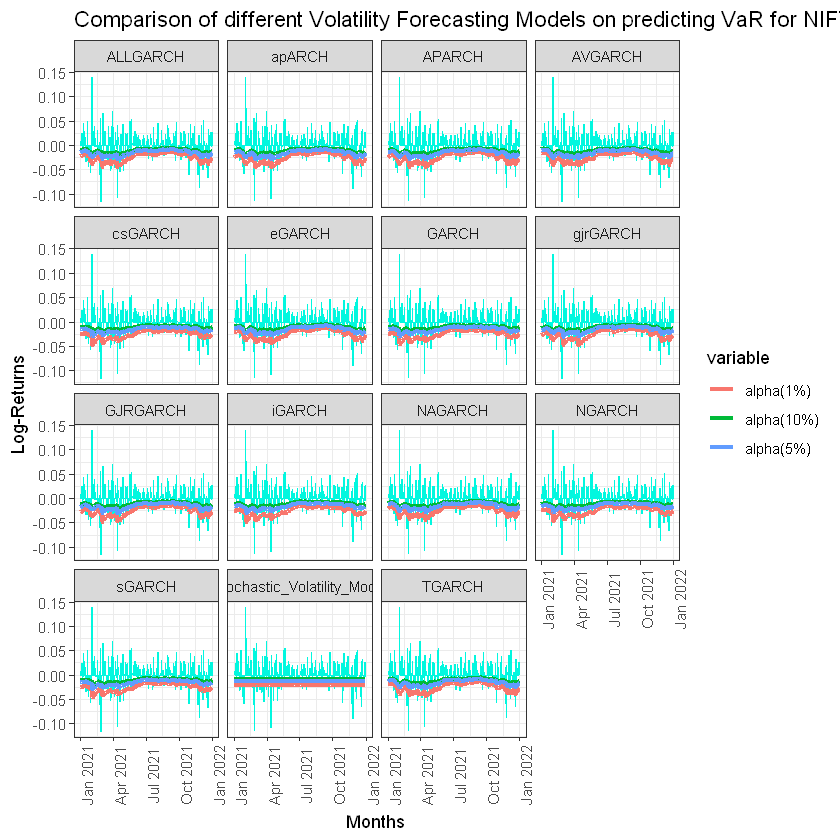

In [41]:
ggplot(VaR_nifty50_2021_long, aes(x=date)) +
geom_col(aes(y=realized), fill="cyan", col="#02f7df") +
geom_line(aes(y=value, color=variable), size=1.25) +
facet_wrap(~model) +
theme_bw() +
theme(axis.text.x=element_text(angle=90)) +
labs(x="Months", y="Log-Returns", title = "Comparison of different Volatility Forecasting Models on predicting VaR for NIFTY50")

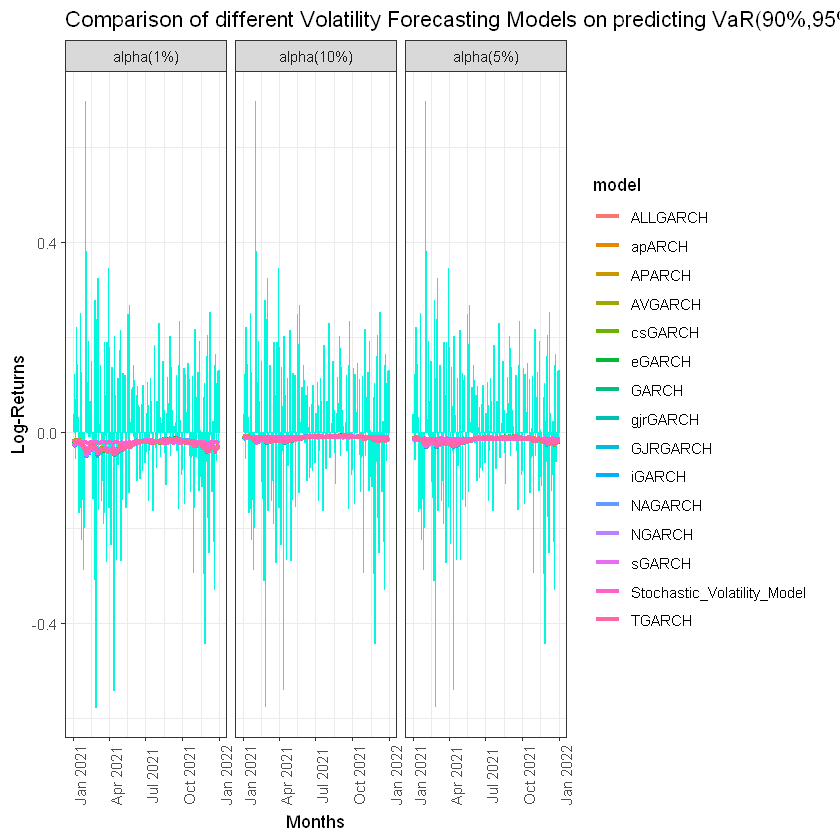

In [43]:
ggplot(VaR_nifty50_2021_long, aes(x=date)) +
geom_col(aes(y=realized), fill="cyan", col="#02f7df") +
geom_line(aes(y=value, color=model), size=1.25) +
facet_wrap(~variable) +
theme_bw() +
theme(axis.text.x = element_text(angle=90)) +
labs(x="Months", y="Log-Returns", title = "Comparison of different Volatility Forecasting Models on predicting VaR(90%,95%,99%) for NIFTY50")

In [44]:
# Number of days each model has breached the various confidence bars (out of 248 trading days)

VaR_nifty50_2021[,lapply(.SD, FUN = function(x){sum(x>realized)}), .SDcols=c(3:5), by=model]

model,alpha(10%),alpha(5%),alpha(1%)
<chr>,<int>,<int>,<int>
sGARCH,23,11,4
eGARCH,22,13,4
iGARCH,22,11,4
apARCH,21,13,4
gjrGARCH,21,12,4
csGARCH,21,10,4
GARCH,23,11,4
TGARCH,22,12,4
AVGARCH,22,14,3


In [48]:
# Saving the result data tables in Excel(.xlsx) format

require(openxlsx)
list_of_datasets <- list("GARCH-(1,1)_variants_Results" = VaR_nifty50_garch_2021, "fGARCH_subvariants_Results" = VaR_nifty50_fgarch_2021, "Stochastic_Volatility_Model" = VaR_nifty50_stochvol_2021, "Cumulative_Res_of_all_15models" = VaR_nifty50_2021)
write.xlsx(list_of_datasets, file = "Comparison of GARCH-(1,1) variants and Stochastic Volatility Model.xlsx")

# <font color = indigo> **CONCLUSION:** </font>

### <font color = Magenta> We have compared the performance of the various available GARCH variants in rugarch package. These models are all deterministic ones. We have compared these to Stochastic Volatility Model in stochvol package. The GARCH variants have clearly outperformed the Stochastic Volatility Model which breached the 90% confidence bar 34 days, 95% confidence bar 18 days and 99% confidence bar 4 days out of 248 trading days in the year 2021 on NIFTY50 returns. 